In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import PCA
from pyspark.sql.functions import mean
import matplotlib.pyplot as plt
import random
from pyspark.sql.types import DoubleType 
import pyspark.sql.functions as F
import pandas as pd

In [2]:
spark = SparkSession.builder.appName("PCAProject").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/08 16:54:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/08 16:54:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
df_raw1 = spark.read.csv("preprocessed_data.csv", header=True, inferSchema=True)
df_raw1 = df_raw1.na.drop()
df_raw1.write.option("header", True).option("delimiter",",").csv("new_file5.csv")

df_raw = spark.read.csv("new_file5.csv",header=True,inferSchema=True)
cols_to_cast = ["District","Ward","Community Area","Year","Arrest","Domestic"]
df_raw = df_raw.select([F.col(c).cast('double') if c in cols_to_cast else c for c in df_raw.columns])
feature_columns = df_raw.columns
for column_name in feature_columns:
    print(column_name)

ID
Case Number
Date
Block
IUCR
Description
Arrest
Domestic
District
Ward
Community Area
FBI Code
Year
Latitude
Longitude
Loc_Descr_Int
Prim_Type_Int


In [5]:
#df_raw = df_raw.na.drop("any")
df_raw.select("District").show()
assembler = VectorAssembler(inputCols=cols_to_cast, outputCol="features", handleInvalid='keep')
assembled_data = assembler.transform(df_raw)

+--------+
|District|
+--------+
|     3.0|
|     4.0|
|     5.0|
|    24.0|
|     5.0|
|     3.0|
|    22.0|
|     5.0|
|    11.0|
|     7.0|
|     6.0|
|     6.0|
|     7.0|
|    25.0|
|    15.0|
|     1.0|
|    10.0|
|    19.0|
|    11.0|
|     3.0|
+--------+
only showing top 20 rows



In [6]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
#DF_3 = df_raw.filter(df_raw["FBI Code"].isNull())
#DF_3.show()
#print(assembled_data)
#assembled_data.show(20)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

In [7]:
print(scaler_model.mean)

[11.283239586112153,22.8396922518063,37.40874829013017,2016.566067668267,0.17694669746797365,0.20621739895449617]


In [8]:
pca = PCA(k=6, inputCol="scaled_features", outputCol="pca_features")
model = pca.fit(scaled_data)
result = model.transform(scaled_data)

23/11/08 16:55:02 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/11/08 16:55:02 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [9]:
explained_variance = model.explainedVariance
print("Explained Variance: ", sum(explained_variance))

Explained Variance:  1.0


In [10]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [11]:
def generate_random_color():
    r = random.random()
    g = random.random()
    b = random.random()
    return (r, g, b)

In [12]:
def fit_kmeans(df_input,column_name='pcaFeatures',num_cluster_centers=3):
    '''
    Requires
    df_input: spark dataframe with column name "features" having vector of real-valued inputs
    num_cluster_centers: integer that tells the algorithm the value of k
    column_name: column name (string) that indicates which vector of features to choose
    Returns
    cluster_data: spark dataframe with predictions
    silhouette_score: float with silhouette score
    wcss: float within cluster sum of squares
    '''
    # Create a K-Means instance
    kmeans = KMeans().setK(num_cluster_centers).setSeed(1)
    
    # Fit the K-Means model to the data
    model = kmeans.fit(df_input)
       
    # Get the cluster assignments for each data point
    clustered_data = model.transform(df_input)

    # Evaluate the clustering using the ClusteringEvaluator
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(clustered_data)

    # Print the WCSS (Within-Cluster Sum of Squares)
    wcss = model.summary.trainingCost
    
    # Get the cluster sizes and centers
    cluster_sizes = clustered_data.groupBy("prediction").count()
    cluster_sizes.show()
    
    # Return the clustered data
    return clustered_data, silhouette_score, wcss

In [13]:
num_centers = 3
clustered_data, _, _ = fit_kmeans(result,column_name='pcaFeatures',num_cluster_centers=num_centers)

+----------+------+
|prediction| count|
+----------+------+
|         1| 96209|
|         2|142437|
|         0|113720|
+----------+------+



In [15]:
# Define a function to perform visualization
def visualize_clusters_2D(clustered_data, feature_1, feature_2,  num_cluster_centers=3):
    '''
    Requires:
    clustered_data: dataframe returned from Kmeans fit
    num_cluster_centers: integer number of clusters
    feature_1: string with identifiers for first column name
    feature_2: string with identifiers for second column name
    '''
    
    # Convert the DataFrame to a Pandas DataFrame for visualization
    pandas_df = clustered_data.select(feature_1, feature_2, "prediction").toPandas()
    
    # Extract the cluster assignments
    cluster_assignments = pandas_df["prediction"]
    
    # Extract the indices for the cluster center
    p1 = feature_columns.index(feature_1)
    p2 = feature_columns.index(feature_2)
    
    # Create a scatter plot for each cluster
    for cluster_id in range(num_cluster_centers):
        # Generate a random color
        random_color = generate_random_color()        
        cluster_data = pandas_df[pandas_df["prediction"] == cluster_id]
        plt.scatter(cluster_data[feature_1], cluster_data[feature_2], color=[random_color], label=f'Cluster {cluster_id}')
        plt.scatter(cluster_data.mean(),cluster_data.mean(), color=[random_color], marker='x', s=500)
    
    # Set labels and title
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.title("K-Means Clustering")
    
    # Show the legend
    plt.legend()
    
    # Display the plot
    plt.show()

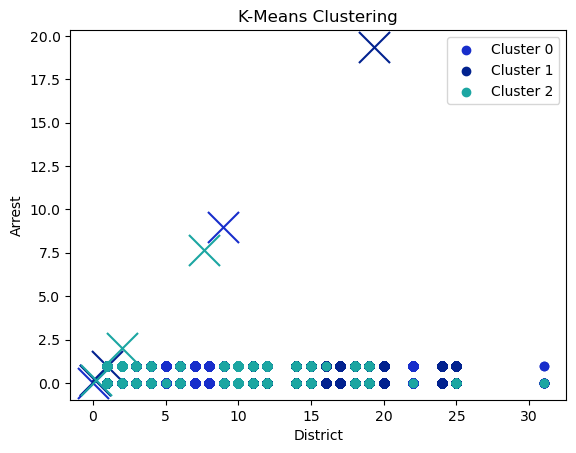

In [16]:
# Convert the DataFrame to a Pandas DataFrame for visualization
feature_1 = "District"
feature_2 = "Arrest"

visualize_clusters_2D(clustered_data, feature_1, feature_2, num_centers)

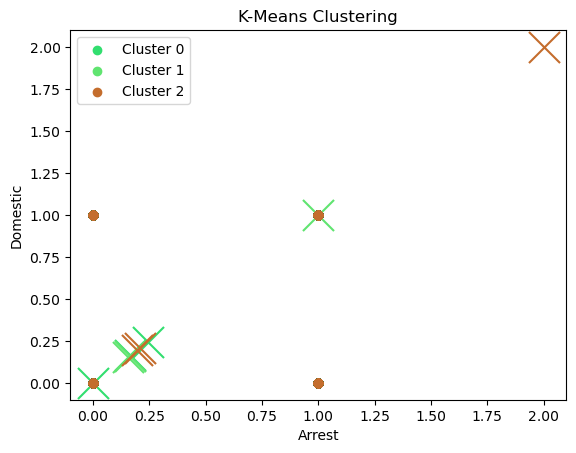

In [17]:
# Convert the DataFrame to a Pandas DataFrame for visualization
feature_1 = "Arrest"
feature_2 = "Domestic"

visualize_clusters_2D(clustered_data, feature_1, feature_2, num_centers)

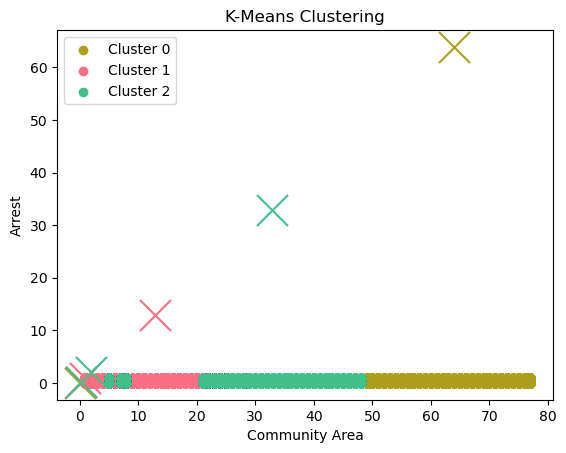

In [18]:
# Convert the DataFrame to a Pandas DataFrame for visualization
feature_1 = "Community Area"
feature_2 = "Arrest"

visualize_clusters_2D(clustered_data, feature_1, feature_2, num_centers)

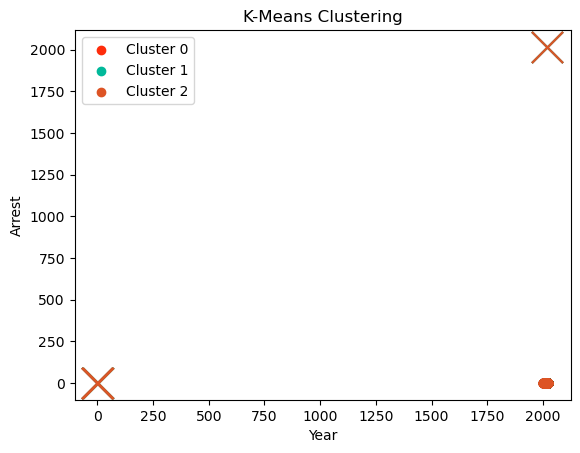

In [19]:
# Convert the DataFrame to a Pandas DataFrame for visualization
feature_1 = "Year"
feature_2 = "Arrest"

visualize_clusters_2D(clustered_data, feature_1, feature_2, num_centers)